In [62]:
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from scipy.stats import shapiro
import pingouin as pg

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Perception of amplitude modulation-induced vibrato

Data analysis and exploration. Helper functions follow. Skip to next cell to see results.

In [63]:
# Globals.
MAX_INTEGER = 2**53 - 1
dpi = 300

# Helpers.
def normalize_slider(df):
    already_normalized = (df[['response', 'slider_start']] <= 1).all().all()
    if not already_normalized:
        df[['response', 'slider_start']] = df[['response', 'slider_start']] / MAX_INTEGER
    return df

def extract_condition(df):
    if 'condition' not in df:
        def process(x):
            return "_".join(x[-1].split('_')[:-1])
        df['condition'] = df['stimulus'].str.split('/').apply(process)
    return df

def extract_trials(df):
    df = df[df['trial_type'] == 'audio-slider-response']
    df = df[~df['stimulus'].str.contains("train")]
    return df

def extract_subject(df):
    if 'subjectNo' not in df:
        df['subjectNo'] = df['stimulus'].str.split("/").apply(lambda x: x[1].split("_")[1])
    return df

def isolate_study(df, study_type):
    assert not df[df['studyType'] == study_type].empty, 'Returns no trials. Already filtered?'
    return df[df['studyType'] == study_type]

def get_summary(df):
    tmp1 = df[['condition', 'response']].groupby('condition').mean()
    tmp2 = df[['condition', 'response']].groupby('condition').std()

    tmp3 = pd.DataFrame()
    tmp3['mean'] = tmp1['response']
    tmp3['std'] = tmp2['response']
    return tmp3

def load(pattern='./prolific/*.csv'):
    files = glob(pattern)
    assert files, 'No csv data found.'

    df = pd.DataFrame()

    for file in files:
        df = df.append(pd.read_csv(file))
        
    return df

    
def macro(study_type):
    df = load()

    df = isolate_study(df, study_type)
    df = extract_trials(df)
    df = normalize_slider(df)
    df = extract_subject(df)
    df = extract_condition(df)
    df = df.reset_index(drop=True)

    df = get_summary(df)
    return df


def filter_by_control(df, threshold=0.6):
    """Find subjectNo where the CONTROL condition was rated greater than threshold."""
    tmp1 = df[df['condition'] == 'CONTROL'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]


def filter_by_basic(df, threshold=0.6):
    """Find subjectNo where the BASIC condition was rated below threshold."""
    tmp1 = df[df['condition'] == 'BASIC'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]


def average_condition_rating_within_subject(df):
    tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
    return tmp.unstack()


def response_histograms(df, bins=20):
    # Get subject's average rating per condition.
    tmp = average_condition_rating_within_subject(df)
    for i, col in enumerate(tmp):
        plt.subplot(1, 2, (i % 2) + 1)
        plt.title(col)
        plt.hist(tmp[col], bins=bins)
        if (i % 2 == 1):
            plt.show()

            
def box_plot(df, study_type, savefig=False, dpi=300):
    tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
    tmp = tmp.unstack()
    tmp.columns = [s.replace('_', ' ') for s in tmp.columns]
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=tmp)
    plt.ylabel('rating')
    plt.xlabel('condition')
    if savefig:
        plt.savefig(f"figs/study_type_{study_type}_boxplot.png", dpi=dpi)
    else:
        plt.show()


def min_max_norm(df):
    min_ = df.groupby('subjectNo')['response'].transform('min')
    max_ = df.groupby('subjectNo')['response'].transform('max')
    df['response'] = (df['response'] - min_)/(max_ - min_)
    return df


def anova_prep(df):
    df = df.groupby(['subjectNo', 'condition'])['response'].mean()
    df = df.unstack()
    tmp = []
    for subject in df.index:
        for condition in df.loc[subject].keys():
                tmp.append(
                {
                    'subjectNo': subject,
                    'condition': condition,
                    'rating': df.loc[subject, condition],
                }
            )            
    return pd.DataFrame(tmp)

def max_time_elapsed(df):
    """Returns the max time elapsed in minutes."""
    return df.groupby('subjectNo')['time_elapsed'].max()/1000/60

def get_num_subjects(df):
    return len(df['subjectNo'].unique())

### Study 1: Perceived fusion.

**Note**: 
Results are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.283868,0.230920
CONTROL,0.823842,0.214081
FM_ONLY,0.648839,0.306427
FROZEN,0.290445,0.217384
PAM,0.800855,0.229898
RAG,0.351403,0.235336
RAG_RAF,0.339307,0.241908
SHUFFLE,0.373763,0.239056
SHUFFLE_RAF,0.332031,0.243205


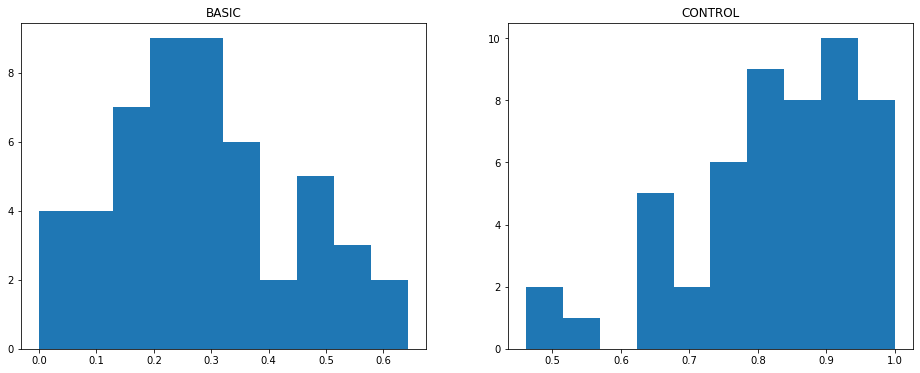

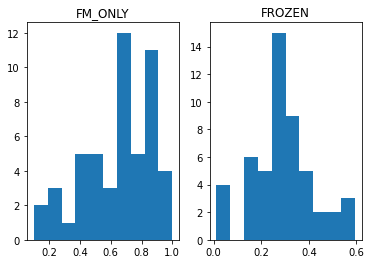

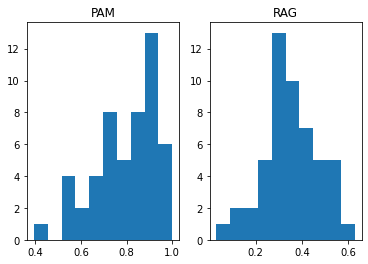

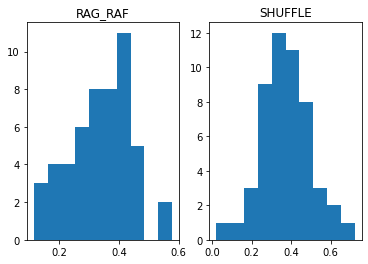

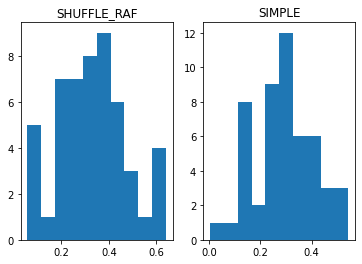

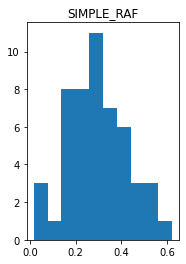

In [64]:
dpi = 300
study_type = 0
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
box_plot(df, study_type, savefig=True, dpi=dpi)
response_histograms(df, 10)

### Study 2: Perceived realism

Perceived realism.

**Note**:
Ratings are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.635573,0.280864
CONTROL,0.383148,0.319881
FM_ONLY,0.495426,0.313030
FROZEN,0.594353,0.265677
PAM,0.380236,0.313012
RAG,0.571733,0.258197
RAG_RAF,0.513825,0.273695
SHUFFLE,0.554518,0.264120
SHUFFLE_RAF,0.461906,0.281960


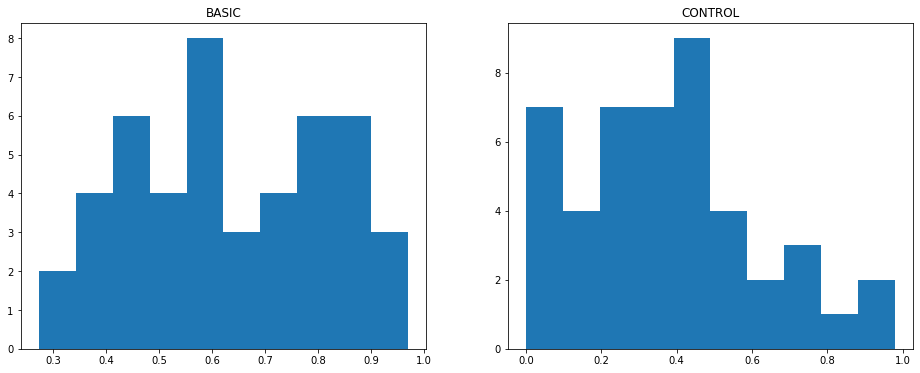

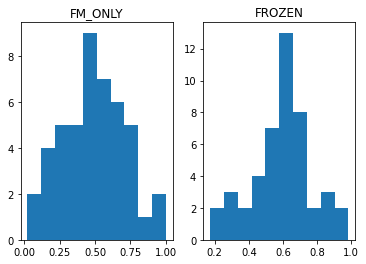

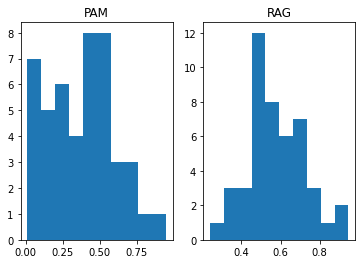

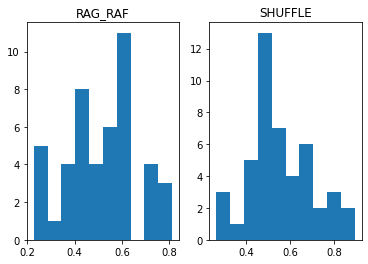

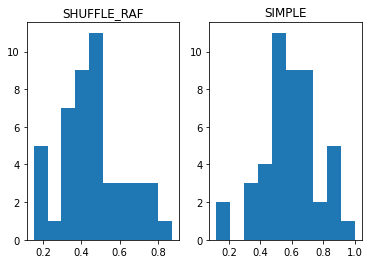

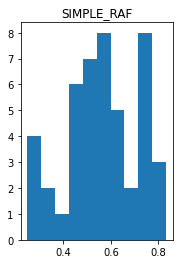

In [65]:
study_type = 1
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
box_plot(df, study_type, savefig=True, dpi=dpi)
response_histograms(df, 10)

### Anova, T-test and check for normal distribution

Condition: BASIC


,W,pval,normal
rating,0.964394,0.169722,True


Condition: CONTROL


,W,pval,normal
rating,0.964787,0.175752,True


Condition: FM_ONLY


,W,pval,normal
rating,0.98944,0.947812,True


Condition: FROZEN


,W,pval,normal
rating,0.973906,0.383736,True


Condition: PAM


,W,pval,normal
rating,0.971008,0.301811,True


Condition: RAG


,W,pval,normal
rating,0.980547,0.628389,True


Condition: RAG_RAF


,W,pval,normal
rating,0.975532,0.436773,True


Condition: SHUFFLE


,W,pval,normal
rating,0.971606,0.317404,True


Condition: SHUFFLE_RAF


,W,pval,normal
rating,0.973068,0.358385,True


Condition: SIMPLE


,W,pval,normal
rating,0.979509,0.586012,True


Condition: SIMPLE_RAF


,W,pval,normal
rating,0.972347,0.337662,True


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,condition,10,450,10.902582,1.099053e-16,0.000028,0.195028,0.220987,False,0.00004,1.645004e-57


,Source,W,ddof1,ddof2,F,p-unc
Friedman,condition,0.162318,9.956522,448.043478,8.719696,4.680287e-13


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,BASIC,CONTROL,True,True,4.702836,45.0,two-sided,0.000025,0.001351,bonf,850.493,1.130040
3,condition,BASIC,PAM,True,True,4.728441,45.0,two-sided,0.000023,0.001242,bonf,919.003,1.189960
5,condition,BASIC,RAG_RAF,True,True,4.388283,45.0,two-sided,0.000068,0.003754,bonf,332.647,0.699784
6,condition,BASIC,SHUFFLE,True,True,3.604177,45.0,two-sided,0.000780,0.042882,bonf,36.545,0.475276
7,condition,BASIC,SHUFFLE_RAF,True,True,5.365670,45.0,two-sided,0.000003,0.000148,bonf,6586.03,0.955670
10,condition,CONTROL,FM_ONLY,True,True,-3.679146,45.0,two-sided,0.000623,0.034259,bonf,44.701,-0.464905
11,condition,CONTROL,FROZEN,True,True,-3.768258,45.0,two-sided,0.000476,0.026168,bonf,56.963,-0.967982
13,condition,CONTROL,RAG,True,True,-4.089356,45.0,two-sided,0.000176,0.009704,bonf,139.831,-0.919501
17,condition,CONTROL,SIMPLE,True,True,-4.238156,45.0,two-sided,0.000110,0.006066,bonf,214.53,-0.971708
20,condition,FM_ONLY,PAM,True,True,3.554408,45.0,two-sided,0.000904,0.049717,bonf,32.011,0.493552


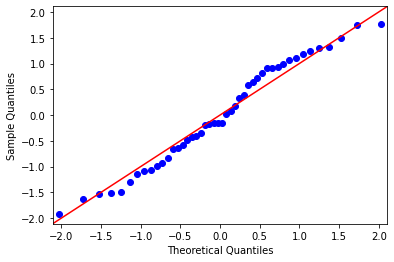

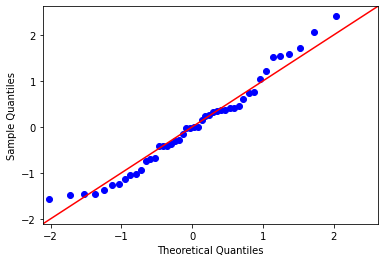

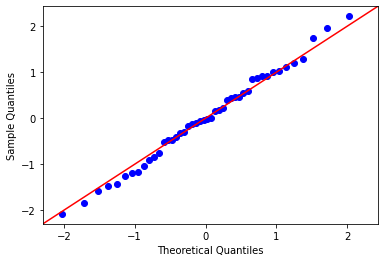

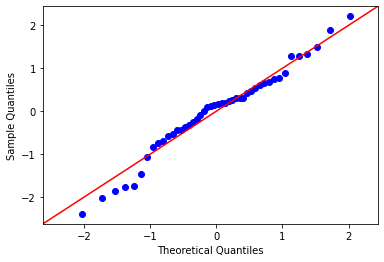

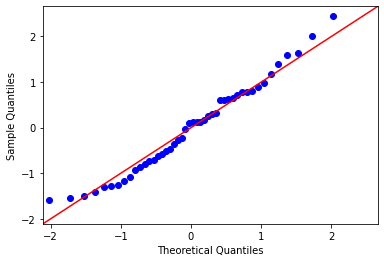

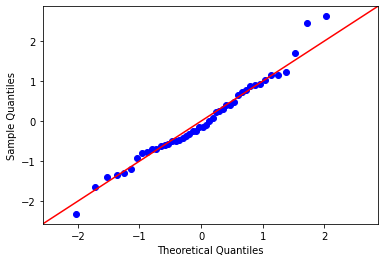

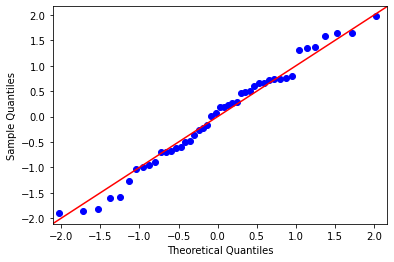

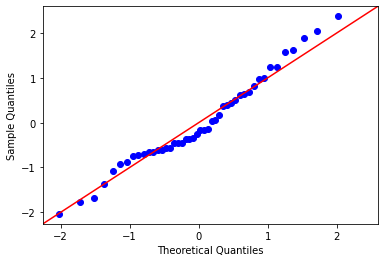

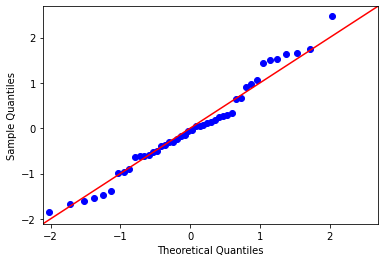

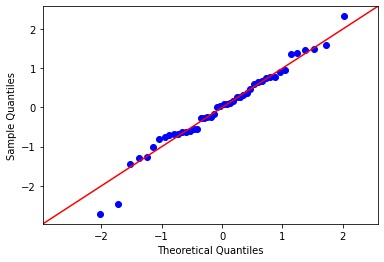

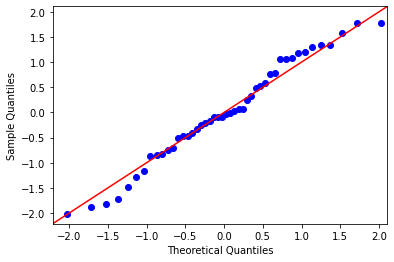

In [66]:
dpi=300

study_type = 1
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = anova_prep(df)
df = df.reset_index(drop=True)

# ANOVA with repeated measures notes.

for condition in df['condition'].unique():
    print(f"Condition: {condition}")
    display(pg.normality(df[df['condition']==condition]['rating']))
    sm.qqplot(df[df['condition']==condition]['rating'], fit=True, line="45")
    plt.savefig(f"./figs/qq_studytype_{study_type}_{condition}.png", dpi=dpi)

display(df.rm_anova(dv='rating', within='condition', subject='subjectNo', correction=True))
display(pg.friedman(data=df, dv='rating', within='condition', subject='subjectNo', method='f'))

tmp = df.pairwise_ttests(dv='rating', within='condition', subject='subjectNo', padjust='bonf')
display(tmp[tmp['p-corr'] <= 0.05])

## Inference

The plan:

- Multiple linear regresion, from timbre toolbox ratings to realness, fusion.
- Descriptor commonalities among stimulus conditions?
- Perhaps, perhaps, train three quantile linear classifiers, 25%, 50%, 75%.

In [69]:
# Step one: load timbre toolbox data and merge with existing df's.

import sys
import os
sys.path.append('../src')
sys.path.append('../audio')
from src.util import load_pickle
from src.defaults import DATA_PATH
from scipy.stats import iqr

pickle_path = os.path.join(DATA_PATH, 'TT_features.pickle')

df = load()

df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

tmp = load_pickle(pickle_path)
tmp = pd.DataFrame(tmp)

df = pd.merge(tmp, df, on='stimulus')

def summarize(df, col):
    """Replace specified column with median and interquartile range.
    
    Assumes that each cell in sed column contains a numpy array.
    """
    
    df[col + '_median'] = df[col].apply(np.median)
    df[col + '_iqr'] = df[col].apply(iqr)
    return df.drop(col, 1)

df = summarize(df, 'energy')
df = summarize(df, 'spectral_centroid')
df = summarize(df, 'spectral_crest')
df = summarize(df, 'spectral_flatness')
df = summarize(df, 'odd_even_ratio')

In [97]:
features = ['energy_median', 'energy_iqr','spectral_centroid_median', 
            'spectral_centroid_iqr','spectral_crest_median', 'spectral_crest_iqr',
            'spectral_flatness_median', 'spectral_flatness_iqr','odd_even_ratio_median', 
            'odd_even_ratio_iqr']

print('MEAN')
display(df.groupby('condition')[features].mean())

print('STD')
display(df.groupby('condition')[features].std())

MEAN


,energy_median,energy_iqr,spectral_centroid_median,spectral_centroid_iqr,spectral_crest_median,spectral_crest_iqr,spectral_flatness_median,spectral_flatness_iqr,odd_even_ratio_median,odd_even_ratio_iqr
condition,,,,,,,,,,
BASIC,0.408875,0.058068,465.073382,41.354183,131.055607,9.950702,0.000086,0.000080,0.976586,0.833835
CONTROL,0.508168,0.000373,439.079175,0.142102,132.181144,0.612500,0.000084,0.000079,0.761288,0.000070
FM_ONLY,0.506367,0.000403,453.415659,4.824924,123.871673,0.621987,0.000087,0.000079,0.987015,0.008755
FROZEN,0.414351,0.058844,467.491486,43.459609,130.927436,10.673773,0.000087,0.000081,0.963898,0.838734
PAM,0.460587,0.036147,452.699322,0.254168,124.043675,0.598312,0.000088,0.000082,0.983470,0.000324
RAG,0.382385,0.131651,454.649418,95.868023,147.381430,28.900012,0.000088,0.000081,1.047372,1.914094
RAG_RAF,0.335707,0.116244,454.169025,80.861295,145.932387,30.333173,0.000087,0.000081,0.989811,1.319159
SHUFFLE,0.412127,0.060010,456.234677,33.090644,130.640789,10.534683,0.000087,0.000082,1.001742,0.563980
SHUFFLE_RAF,0.384654,0.056556,456.538398,32.534481,130.253561,10.401398,0.000088,0.000082,0.967176,0.455170


STD


,energy_median,energy_iqr,spectral_centroid_median,spectral_centroid_iqr,spectral_crest_median,spectral_crest_iqr,spectral_flatness_median,spectral_flatness_iqr,odd_even_ratio_median,odd_even_ratio_iqr
condition,,,,,,,,,,
BASIC,0.089062,0.012653,0.118172,0.142500,0.050625,0.155499,0.000007,0.000013,0.000829,0.024924
CONTROL,0.116333,0.000097,0.011314,0.037527,0.052540,0.083930,0.000008,0.000015,0.000023,0.000011
FM_ONLY,0.126488,0.000106,0.046487,0.050263,0.019952,0.034578,0.000008,0.000014,0.000066,0.000201
FROZEN,0.090953,0.012913,0.134158,0.167697,0.068321,0.187145,0.000008,0.000013,0.000923,0.001490
PAM,0.113704,0.008919,0.010096,0.072190,0.029220,0.045107,0.000009,0.000016,0.000036,0.000053
RAG,0.095487,0.065060,5.058871,49.422347,16.208461,10.893893,0.000008,0.000013,0.129343,1.289652
RAG_RAF,0.078988,0.040144,4.731218,29.120257,9.075847,10.144171,0.000008,0.000013,0.068132,0.582906
SHUFFLE,0.095843,0.025327,5.654409,12.673469,2.778726,3.607060,0.000008,0.000014,0.063156,0.177760
SHUFFLE_RAF,0.080868,0.013838,1.834715,5.218410,1.375269,1.334024,0.000008,0.000014,0.024877,0.114132


BASIC


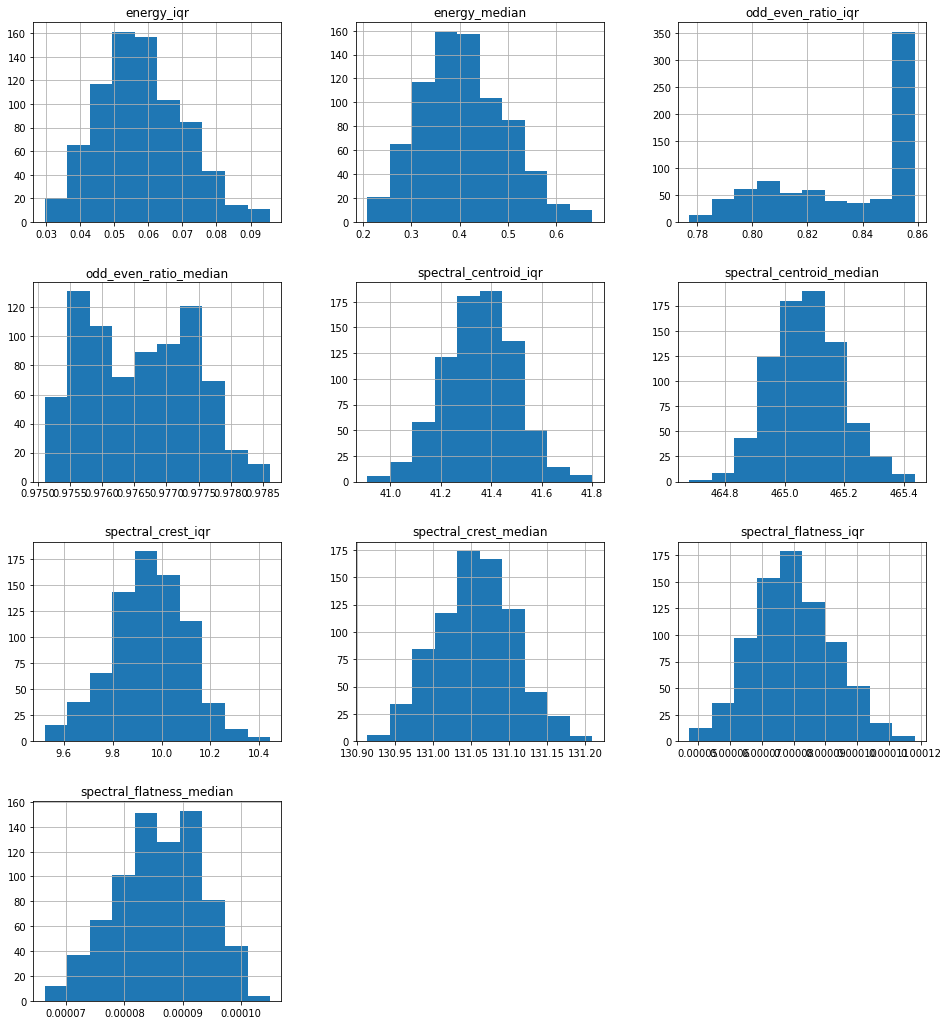

FROZEN


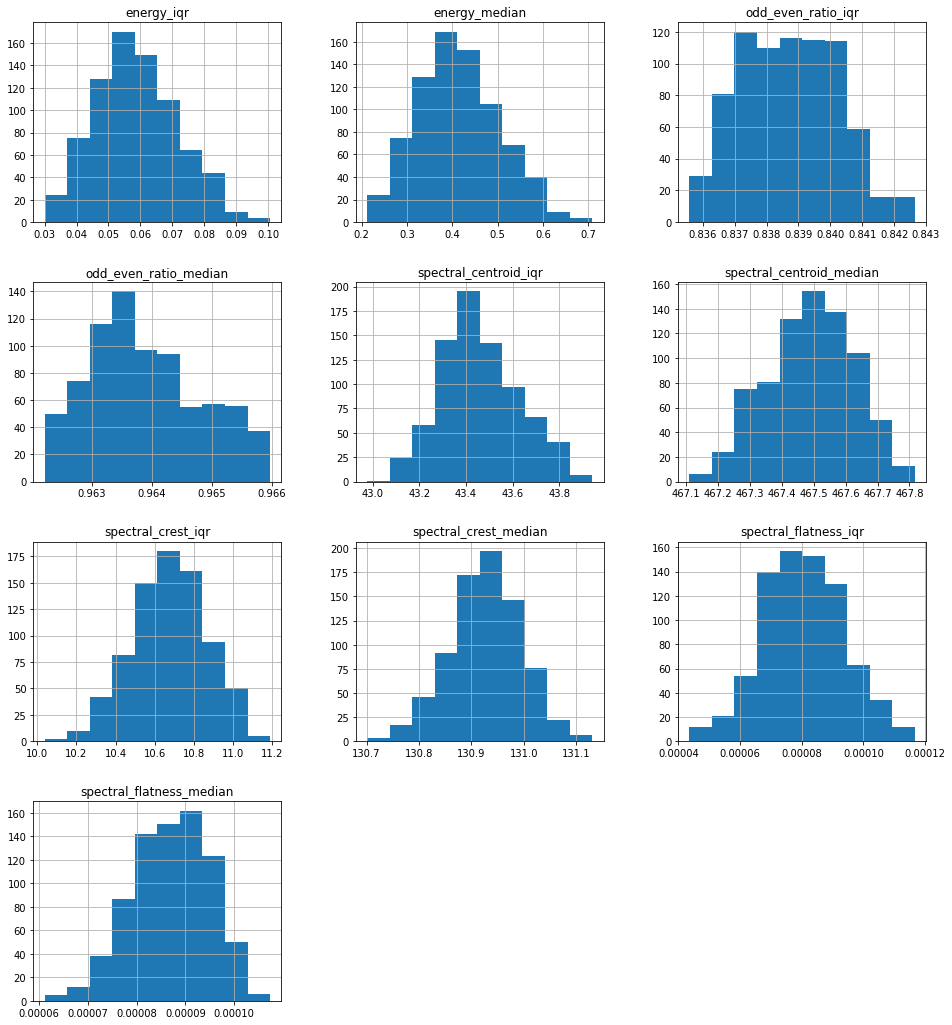

RAG


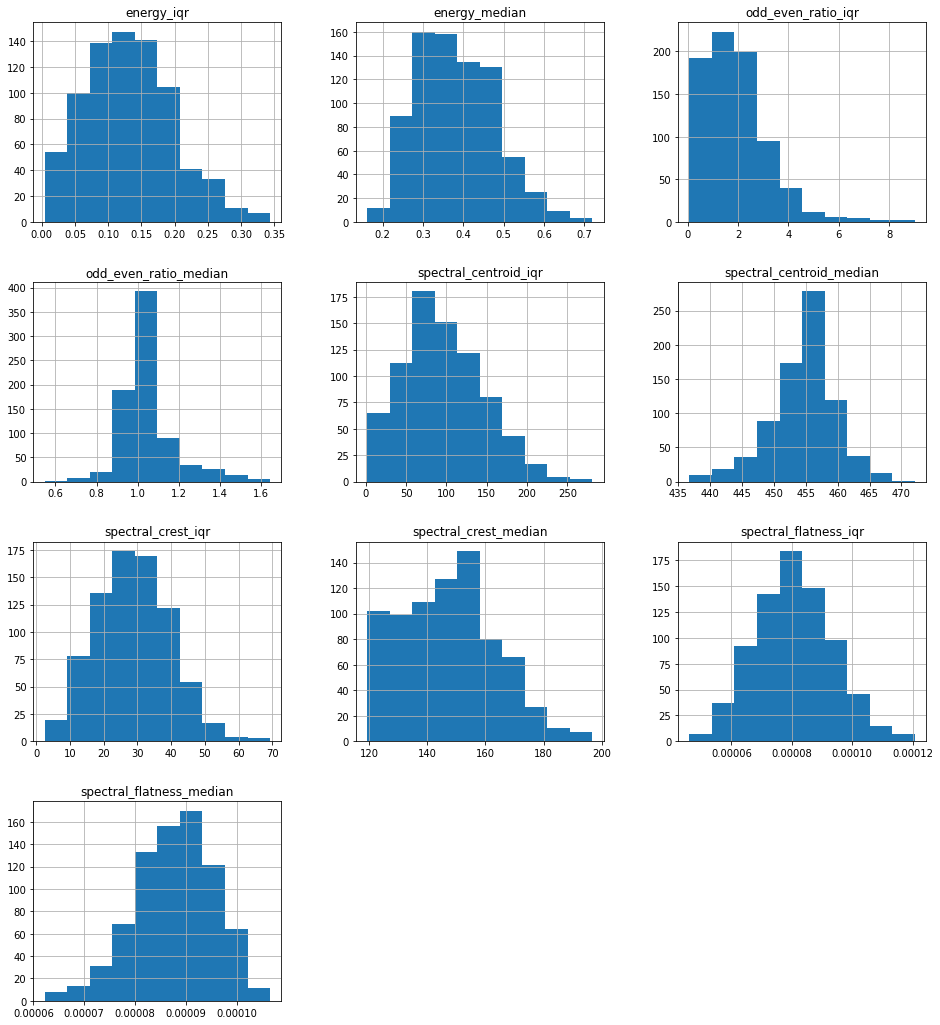

SHUFFLE


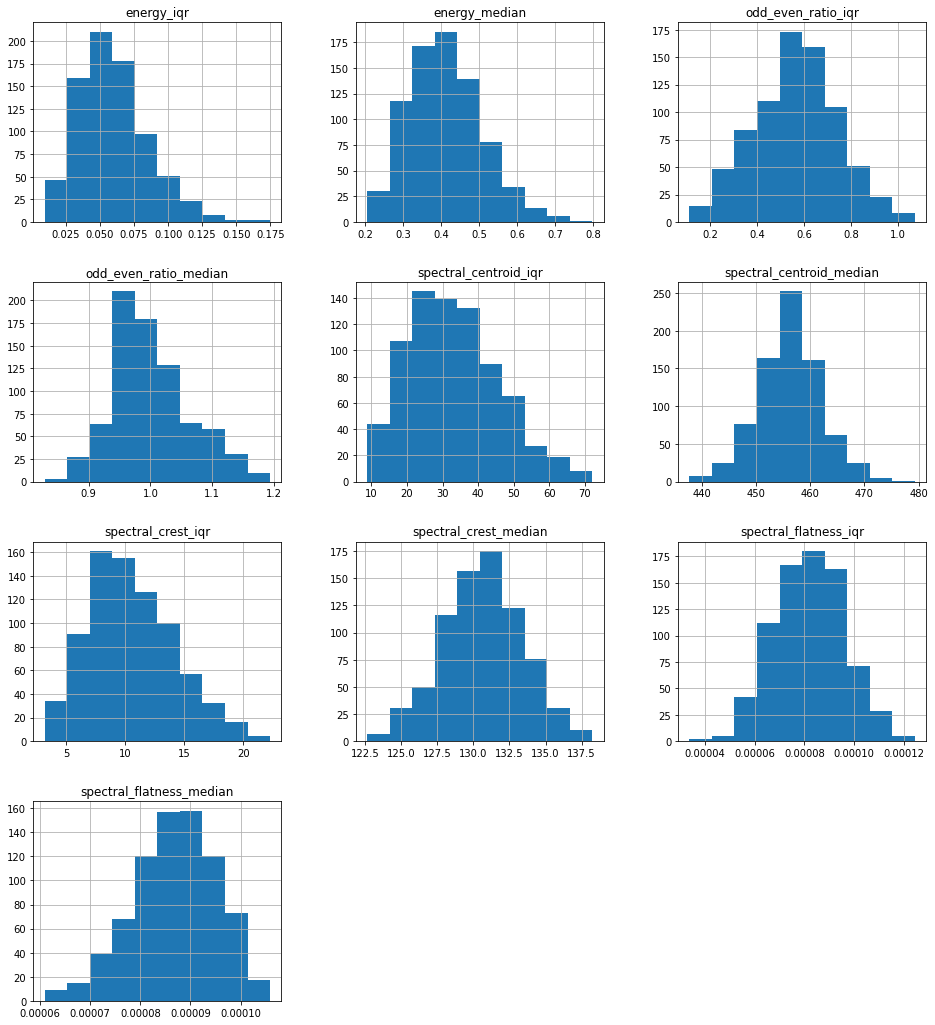

SIMPLE


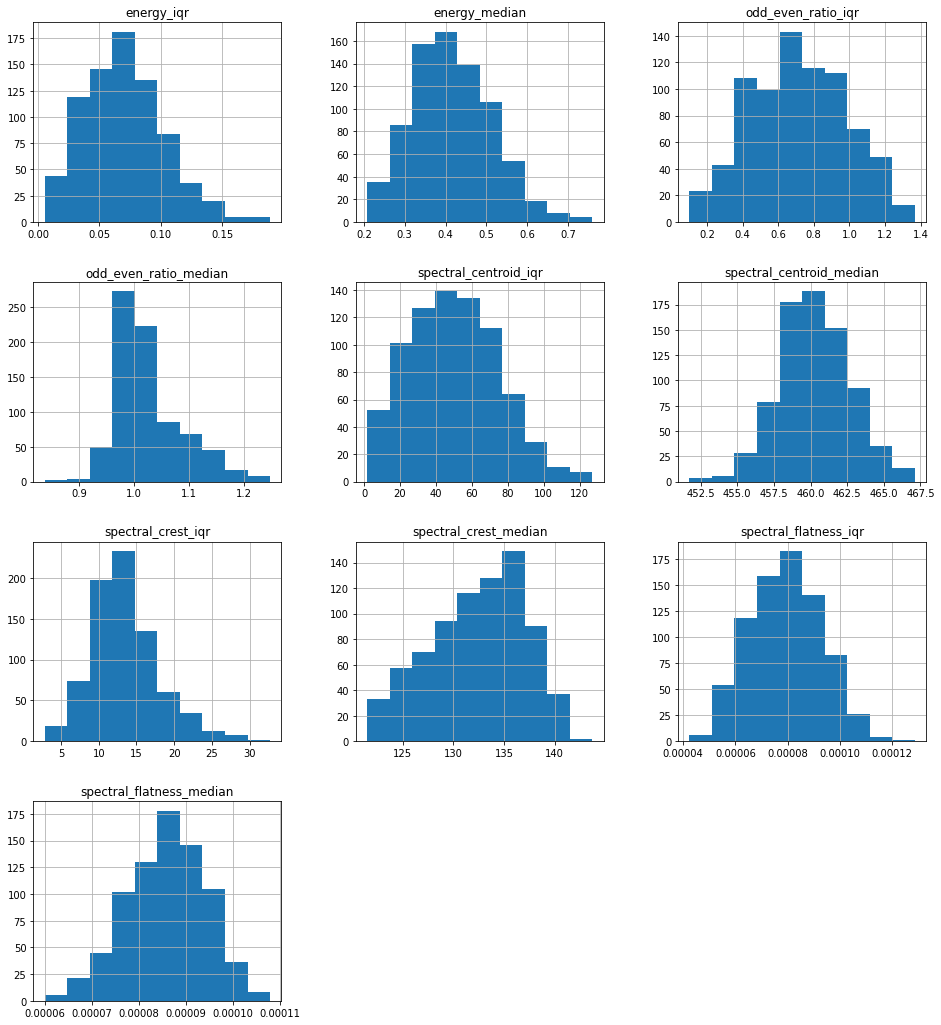

In [57]:
# Distribution of features among different stimulus types.

# Spectral centroid iqr is more diffuse in random conditions.
# Can we find some pattern, not in the conditions, but in the features?

conditions = [
    'BASIC', 
    'FROZEN', 
    #'CONTROL', 'FM_ONLY', 'PAM',
    'RAG', #'RAG_RAF', 
    'SHUFFLE', #'SHUFFLE_RAF', 
    'SIMPLE', #'SIMPLE_RAF'
             ]

for condition in conditions:
    print(condition)
    df[df['condition'] == condition][features].hist(figsize = (16,18))
    plt.show()

In [85]:
feature = 'spectral_crest_iqr'

tmp = df.sort_values(by=[feature])
display(tmp)

,stimulus,view_history,rt,trial_type,trial_index,time_elapsed,internal_node_id,prolificID,studyID,sessionID,...,energy_median,energy_iqr,spectral_centroid_median,spectral_centroid_iqr,spectral_crest_median,spectral_crest_iqr,spectral_flatness_median,spectral_flatness_iqr,odd_even_ratio_median,odd_even_ratio_iqr
4025,audio/subject_285/block_1/CONTROL_0.wav,NaN,1467.0,audio-slider-response,81,394132,0.0-11.0-0.21,5f1c50af06c7d64c30b17506,606149aeb3947c62b99042ae,606238336e660183ede7148c,...,0.480132,0.000503,439.062451,0.104696,132.268998,0.337456,0.000090,0.000111,0.761307,0.000085
1525,audio/subject_230/block_0/CONTROL_3.wav,NaN,3021.0,audio-slider-response,43,673255,0.0-8.0-0.29,5ef5f63c7aa58727ac4f8588,605e50fb8cbc14076c9a36b6,6060ab07388e8445353d193c,...,0.551034,0.000163,439.050411,0.187484,132.097920,0.353962,0.000083,0.000066,0.761280,0.000080
3715,audio/subject_332/block_0/CONTROL_3.wav,NaN,3501.0,audio-slider-response,33,200704,0.0-8.0-0.19,5f21be8126b25311f0fac397,606149aeb3947c62b99042ae,60625b3cad11e1a934a7775e,...,0.765986,0.000477,439.070929,0.185618,132.217311,0.392501,0.000098,0.000068,0.761273,0.000067
1301,audio/subject_231/block_1/CONTROL_0.wav,NaN,2331.0,audio-slider-response,85,328906,0.0-11.0-0.25,5fdc9a58c0e40a22b2592664,605e50fb8cbc14076c9a36b6,6060a80baa1c918ac0dacbbf,...,0.398632,0.000365,439.057620,0.150119,132.141381,0.398665,0.000083,0.000108,0.761317,0.000058
2721,audio/subject_297/block_1/CONTROL_2.wav,NaN,5653.0,audio-slider-response,97,863507,0.0-11.0-0.37,602464ee6f1d051573de7518,606149aeb3947c62b99042ae,60624607a41417dd63bce868,...,0.640744,0.000243,439.055306,0.173615,132.159577,0.402785,0.000096,0.000069,0.761260,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,audio/subject_184/block_0/RAG_1.wav,NaN,3109.0,audio-slider-response,45,222253,0.0-8.0-0.31,5feb59016d65c5bf98940b28,605e50fb8cbc14076c9a36b6,6060a6d89cfa745a6ed65648,...,0.360175,0.216735,466.848690,220.614645,119.874725,62.430813,0.000083,0.000093,0.983116,0.402281
2952,audio/subject_269/block_1/RAG_RAF_3.wav,NaN,1861.0,audio-slider-response,64,303873,0.0-11.0-0.4,5c9d28816b36c400013cc430,606149aeb3947c62b99042ae,6062270591dd541a36d8fedd,...,0.250901,0.139809,441.304110,104.889608,160.927528,66.158068,0.000086,0.000084,0.915337,2.147310
7936,audio/subject_265/block_0/RAG_2.wav,NaN,4352.0,audio-slider-response,30,207291,0.0-8.0-0.16,5f0ccbd3de11c316e48ae99d,606149aeb3947c62b99042ae,606225e913658e6d1efdddf4,...,0.256782,0.205631,454.988934,236.128954,125.042697,66.248835,0.000089,0.000065,1.096553,0.694499
8122,audio/subject_217/block_0/RAG_3.wav,NaN,2109.0,audio-slider-response,40,100855,0.0-8.0-0.26,5f19214cc5b3a417c1b823db,605e50fb8cbc14076c9a36b6,6060a5c4c250cf9e12ab0bf1,...,0.290518,0.164455,467.552621,243.427287,119.272208,66.600167,0.000088,0.000091,0.998509,0.671334


FileNotFoundError: [Errno 2] No such file or directory: 'audio/subject_302/block_1/RAG_0.wav'

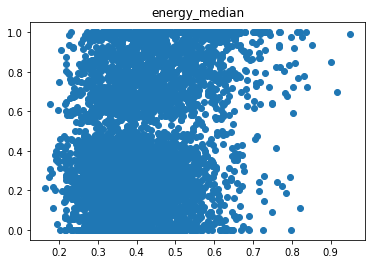

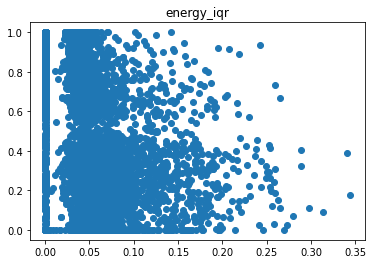

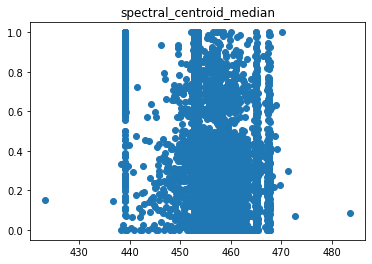

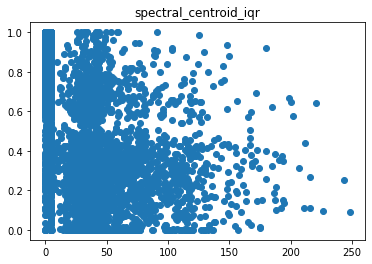

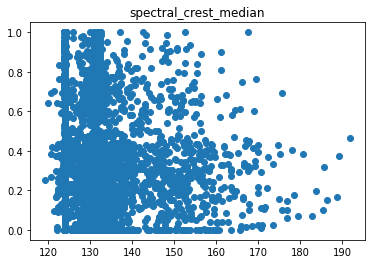

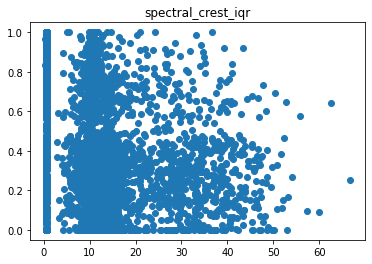

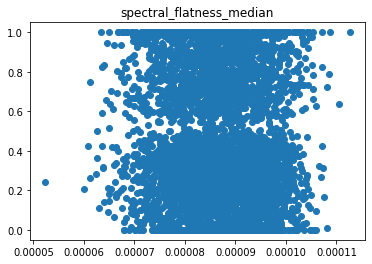

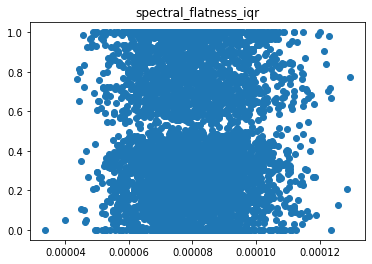

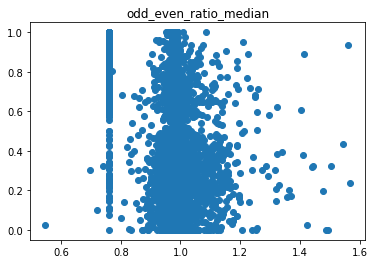

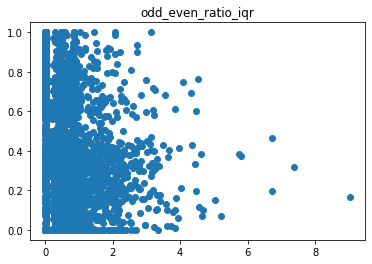

In [88]:
fused_df = isolate_study(df, study_type=0)
realism_df = isolate_study(df, study_type=1)



_df = fused_df

for feature in features:
    plt.title(feature)
    plt.scatter(_df[feature], _df['response'])
    plt.show()

### Explorations

In [269]:
study_type = 0
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = min_max_norm(df)
df = extract_condition(df)

print(f"Total N = {get_num_subjects(df)}")
filter_by_control(df, 0.25)
# max_time_elapsed(df).mean()


# df = extract_condition(df)
# df = min_max_norm(df)
# df = anova_prep(df)
# df = df.reset_index(drop=True)
# df = average_condition_rating_within_subject(df)

Total N = 51
N = 40
8


In [252]:
.37*60

22.2

In [188]:
tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
tmp = tmp.unstack()



In [189]:
tmp.columns

Index(['BASIC', 'CONTROL', 'FM ONLY', 'FROZEN', 'PAM', 'RAG', 'RAG RAF',
       'SHUFFLE', 'SHUFFLE RAF', 'SIMPLE', 'SIMPLE RAF'],
      dtype='object')